# Churn Project Preliminary Modeling

### Logistic Regression - Baseline

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/ubuntu/MyTools/src')
from MLModelingTools import model_test, model_testN

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Read the training data file.  This file was created by running the notebooks:
* Telecom to SQL
* Telecom clean and eda

In [3]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv')


# Sometimes the index column is read as an unnamed column, if so drop it
if 'Unnamed: 0' in train_df.columns :
    train_df = train_df.drop('Unnamed: 0', axis=1)
    
train_df.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'Month-to-month', 'One year', 'DSL', 'Fiber optic', 'Female'],
      dtype='object')

In [4]:
# Define which columns we're going to use in our modeling.
train_columns = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Month-to-month', 'One year', 'Fiber optic', 'Female']
X = train_df[train_columns]
y= train_df['Churn']

### Balance the imbalanced dataset

In [5]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [6]:
# Create a logistic regression model that we can use as a baseline
model_1 = LogisticRegression(solver = 'liblinear', C=0.5)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

In [7]:
model_1.fit(X_train,y_train)
y_hat = model_1.predict(X_test)
print(accuracy_score(y_test, y_hat))

0.7976878612716763


In [8]:
def calc_roc_data(model, X_dat, y_dat, n_step) :
    threshold_list = np.linspace(0, 1, n_step)
    roc_data = []

    for i, threshold in enumerate(threshold_list) :
        y_predict = (model.predict_proba(X_dat)[:, 1] >= threshold)
        confusion_m = confusion_matrix(y_dat, y_predict)
        fpr = confusion_m[1][0] / (confusion_m[1][0]+confusion_m[1][1])
        tpr = confusion_m[0][0] / (confusion_m[0][0]+confusion_m[0][1])
        roc_data.append([threshold, fpr, tpr])
    
    return roc_data

def cal_f_beta(tpr, fpr, beta) :
    weighted_ave = (beta**2 * (tpr+1) * fpr) / (beta**2 + 1)
    return (tpr*fpr) / weighted_ave

In [9]:
test_dat = calc_roc_data(model_1, X_test, y_test, 20)

In [20]:
x_plt_log = [test_dat[i][1] for i in range(len(test_dat))]
y_plt_log = [test_dat[i][2] for i in range(len(test_dat))]


Text(0.5, 1.0, 'ROC\n')

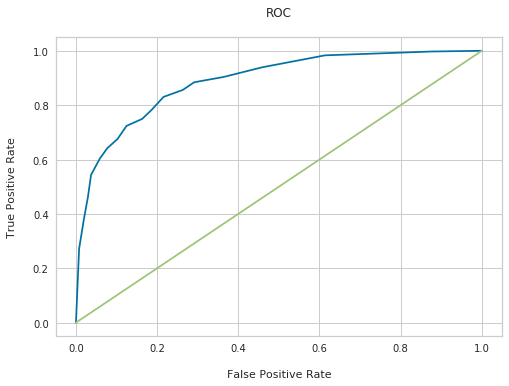

In [21]:
plt.plot(x_plt_log, y_plt_log)
plt.plot([0,1],[0,1])
plt.xlabel('\nFalse Positive Rate')
plt.ylabel('True Positive Rate\n')
plt.title('ROC\n')

### Create model validation pipeline and do grid search for KNN Model

In [22]:
from imblearn.pipeline import Pipeline
sm = SMOTE(random_state=42)
knn = KNeighborsClassifier()
steps = [('smt', sm), ('KNN', knn)]

pipeline = Pipeline(steps) # define the pipeline object.

In [23]:
param_grid = {
    'smt__random_state': [45],
    'KNN__n_neighbors': [2, 4, 6, 8, 10],
}


In [24]:
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

In [25]:
grid.fit(X_train, y_train)
print("score = %3.2f" %(grid.score(X_test,y_test)))
print(grid.best_params_)
#>>> score = 0.60
#    {'SVM__C': 100, 'SVM__gamma': 0.1}

score = 0.81
{'KNN__n_neighbors': 4, 'smt__random_state': 45}


In [26]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
roc_data = calc_roc_data(knn, X_test, y_test, 20)
x_plt_knn = [roc_data[i][1] for i in range(len(roc_data))]
y_plt_knn = [roc_data[i][2] for i in range(len(roc_data))]

Text(0.5, 1.0, 'ROC for KNN (neighbors = 6\n')

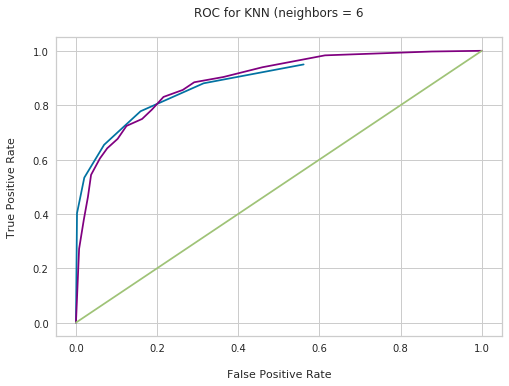

In [28]:
plt.plot(x_plt_knn, y_plt_knn)
plt.plot(x_plt_log, y_plt_log, color='purple')
plt.plot([0,1],[0,1])
plt.xlabel('\nFalse Positive Rate')
plt.ylabel('True Positive Rate\n')
plt.title('ROC for KNN (neighbors = 6\n')

<Figure size 2400x1650 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


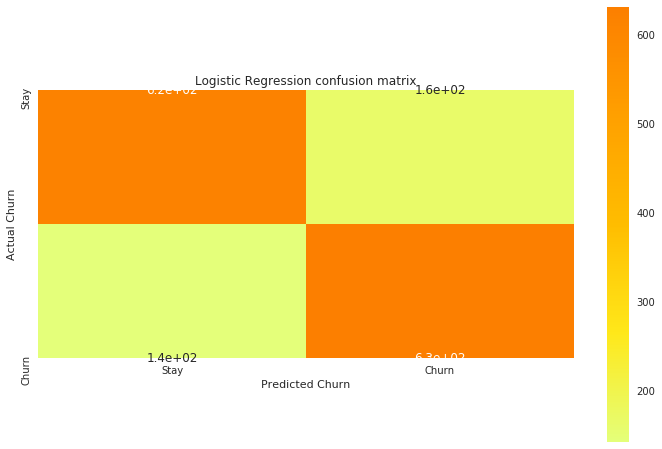

In [18]:
plt.figure(dpi=300)
plt.figure(figsize = (12,8))
sns.heatmap(logistic_confusion, cmap=plt.cm.Wistia, annot=True, square=True,
           xticklabels=['Stay', 'Churn'],
           yticklabels=['Stay', 'Churn'])

plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.title('Logistic Regression confusion matrix');

In [28]:
'''
visualizer = ClassificationReport(model_1)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
'''

'\nvisualizer = ClassificationReport(model_1)\n\nvisualizer.fit(X_train, y_train)\nvisualizer.score(X_test, y_test)\nvisualizer.show()\n'

In [29]:
'''
from yellowbrick.features import parallel_coordinates
from yellowbrick.classifier import classification_report
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
visualizer.show()

# Displays parallel coordinates
#g = parallel_coordinates(X, y)

# Displays classification report
#g = classification_report(LogisticRegression(), X, y)
'''

'\nfrom yellowbrick.features import parallel_coordinates\nfrom yellowbrick.classifier import classification_report\nfrom yellowbrick.features import Rank2D\n\nvisualizer = Rank2D(algorithm="pearson")\nvisualizer.fit_transform(X)\nvisualizer.show()\n\n# Displays parallel coordinates\n#g = parallel_coordinates(X, y)\n\n# Displays classification report\n#g = classification_report(LogisticRegression(), X, y)\n'